In [1]:
import os
import requests
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, SpectralClustering

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

import umap

In [2]:
pd.options.display.max_columns = 200

In [3]:
dataset_sufix = 'L2'

# Data Loading

In [4]:
salurbal_df = pd.read_excel( '../data/base_l2.xlsx' )

In [5]:
# Deleting columns
del salurbal_df[ 'SALID1' ]
del salurbal_df[ 'SALID2' ]

del salurbal_df[ 'urb-pmp-1' ]
del salurbal_df[ 'urb-pmp-2' ]
del salurbal_df[ 'urb-pmp-3' ]
del salurbal_df[ 'urb-pmp-4' ]
del salurbal_df[ 'urb-pmp-5' ]
del salurbal_df[ 'urb-pmp-6' ]

del salurbal_df[ 'stt-pmp-1' ]
del salurbal_df[ 'stt-pmp-2' ]
del salurbal_df[ 'stt-pmp-3' ]
del salurbal_df[ 'stt-pmp-4' ]
del salurbal_df[ 'stt-pmp-5' ]
del salurbal_df[ 'stt-pmp-6' ]

In [6]:
salurbal_df.shape

(1351, 20)

In [7]:
salurbal_df.dtypes

Country                   object
L1Name                    object
L2Namev2                  object
BECNURBPTCHL2              int64
BECPTCHDENSL2            float64
BECAWMNSHPINDXL2         float64
BECAWMNNNGHL2            float64
BECEFFMESHSIZEL2         float64
BECAWAVGPTCHAREAL2       float64
BECAWEDGDENSL2           float64
BECPRSBRTL2                int64
BECPRSSUBWAYL2             int64
BECADCRCTYAVGL2          float64
BECADINTDENSL2           float64
BECADSTTDENSL2           float64
BECADSTTPNODEAVGL2       float64
BECADSTTLGAVGL2          float64
BECURBTRVDELAYINDEXL2    float64
urb-perfil                 int64
stt-perfil                 int64
dtype: object

In [8]:
salurbal_df.head()

,Country,L1Name,L2Namev2,BECNURBPTCHL2,BECPTCHDENSL2,BECAWMNSHPINDXL2,BECAWMNNNGHL2,BECEFFMESHSIZEL2,BECAWAVGPTCHAREAL2,BECAWEDGDENSL2,BECPRSBRTL2,BECPRSSUBWAYL2,BECADCRCTYAVGL2,BECADINTDENSL2,BECADSTTDENSL2,BECADSTTPNODEAVGL2,BECADSTTLGAVGL2,BECURBTRVDELAYINDEXL2,urb-perfil,stt-perfil
0,Argentina,Bahia Blanca,Bahía Blanca,487,0.2131,5.1337,76.6491,77.6599,2644.8742,0.420828,0,0,1.032761,3.672485,939.287799,3.411006,144.004054,0.104629,1,6
1,Argentina,Buenos Aires,CABA - Comuna 12,1,0.0642,1.4735,NaN,1557.1800,1557.1800,14.988633,1,1,1.010627,102.376535,18590.830836,3.619105,99.891610,0.168965,6,5
2,Argentina,Buenos Aires,CABA - Comuna 13,13,0.8836,2.5395,60.0462,1264.0834,1359.9129,24.739527,1,1,1.026108,90.571453,16060.259206,3.473831,98.454629,0.240852,2,5
3,Argentina,Buenos Aires,CABA - Comuna 4,8,0.3611,2.2122,67.1673,1990.2022,2091.1138,18.119355,1,1,1.027101,79.577418,14502.014548,3.361758,104.423094,0.156420,2,5
4,Argentina,Buenos Aires,CABA - Comuna 6,1,0.1460,1.2914,NaN,684.9000,684.9000,19.798511,0,1,1.005764,83.147041,15379.258560,3.525963,106.145510,0.248183,6,5


# Data Cleaning

In [10]:
salurbal_df.isnull().sum()

Country                   0
L1Name                    2
L2Namev2                  0
BECNURBPTCHL2             0
BECPTCHDENSL2             0
BECAWMNSHPINDXL2          0
BECAWMNNNGHL2            55
BECEFFMESHSIZEL2          0
BECAWAVGPTCHAREAL2        0
BECAWEDGDENSL2            0
BECPRSBRTL2               0
BECPRSSUBWAYL2            0
BECADCRCTYAVGL2           0
BECADINTDENSL2            0
BECADSTTDENSL2            0
BECADSTTPNODEAVGL2        0
BECADSTTLGAVGL2           0
BECURBTRVDELAYINDEXL2     0
urb-perfil                0
stt-perfil                0
dtype: int64

In [19]:
salurbal_df.loc[ salurbal_df[ 'BECAWMNNNGHL2' ].isnull(), 'BECAWMNNNGHL2' ] = salurbal_df[ 'BECAWMNNNGHL2' ].median()

In [21]:
salurbal_df.rename( columns = { 'stt-perfil' : 'TR_PROFILE', 'urb-perfil' : 'UL_PROFILE' }, inplace = True )

In [22]:
new_features = dict()
for feature in [ feature.replace( dataset_sufix, '' ) for feature in salurbal_df.columns.tolist() if feature.endswith( dataset_sufix ) ]:
    new_features[ feature + dataset_sufix ] = feature
salurbal_df.rename( columns = new_features, inplace = True )

In [23]:
ul_features = [ 'BECAWMNSHPINDX', 'BECEFFMESHSIZE', 'BECAWMNNNGH', 'BECAWEDGDENS', 'BECPTCHDENS', 'BECAWAVGPTCHAREA' ]

In [24]:
tr_features = [ 'BECADSTTDENS', 'BECADSTTLGAVG', 'BECADINTDENS', 'BECADCRCTYAVG', 'BECADSTTPNODEAVG' ]

In [25]:
salurbal_df.head()

,Country,L1Name,L2Namev2,BECNURBPTCH,BECPTCHDENS,BECAWMNSHPINDX,BECAWMNNNGH,BECEFFMESHSIZE,BECAWAVGPTCHAREA,BECAWEDGDENS,BECPRSBRT,BECPRSSUBWAY,BECADCRCTYAVG,BECADINTDENS,BECADSTTDENS,BECADSTTPNODEAVG,BECADSTTLGAVG,BECURBTRVDELAYINDEX,UL_PROFILE,TR_PROFILE
0,Argentina,Bahia Blanca,Bahía Blanca,487,0.2131,5.1337,76.64910,77.6599,2644.8742,0.420828,0,0,1.032761,3.672485,939.287799,3.411006,144.004054,0.104629,1,6
1,Argentina,Buenos Aires,CABA - Comuna 12,1,0.0642,1.4735,76.50085,1557.1800,1557.1800,14.988633,1,1,1.010627,102.376535,18590.830836,3.619105,99.891610,0.168965,6,5
2,Argentina,Buenos Aires,CABA - Comuna 13,13,0.8836,2.5395,60.04620,1264.0834,1359.9129,24.739527,1,1,1.026108,90.571453,16060.259206,3.473831,98.454629,0.240852,2,5
3,Argentina,Buenos Aires,CABA - Comuna 4,8,0.3611,2.2122,67.16730,1990.2022,2091.1138,18.119355,1,1,1.027101,79.577418,14502.014548,3.361758,104.423094,0.156420,2,5
4,Argentina,Buenos Aires,CABA - Comuna 6,1,0.1460,1.2914,76.50085,684.9000,684.9000,19.798511,0,1,1.005764,83.147041,15379.258560,3.525963,106.145510,0.248183,6,5


# Data Exploration

sns.pairplot( salurbal_df, vars = ul_features, hue = 'UL_PROFILE' )

sns.pairplot( salurbal_df, vars = tr_features, hue = 'TR_PROFILE' )

# Geocoding

In [26]:
GOOGLE_API = os.environ[ 'GOOGLE_API' ]
URL = 'https://maps.googleapis.com/maps/api/geocode/json'

In [27]:
for index, row in salurbal_df.iterrows():
    try:
        #print( index )
        address = row[ 'L2Namev2' ] + ', ' + row[ 'L1Name' ] + ', ' + row[ 'Country' ]
        #print( address )
        data = requests.get( URL, params = { 'key' : GOOGLE_API, 'address' : address } ).json()
        lat = data[ 'results' ][ 0 ][ 'geometry' ][ 'location' ][ 'lat' ]
        lng = data[ 'results' ][ 0 ][ 'geometry' ][ 'location' ][ 'lng' ]
        salurbal_df.loc[ index, 'CentLatitude' ] = lat
        salurbal_df.loc[ index, 'CentLongitude' ] = lng
    except IndexError:
        pass
    except TypeError:
        pass

In [28]:
for index, row in salurbal_df.loc[ salurbal_df[ 'L1Name' ].isnull() ].iterrows():
    try:
        #print( index )
        address = row[ 'L2Namev2' ] + ', ' + row[ 'Country' ]
        #print( address )
        data = requests.get( URL, params = { 'key' : GOOGLE_API, 'address' : address } ).json()
        lat = data[ 'results' ][ 0 ][ 'geometry' ][ 'location' ][ 'lat' ]
        lng = data[ 'results' ][ 0 ][ 'geometry' ][ 'location' ][ 'lng' ]
        salurbal_df.loc[ index, 'CentLatitude' ] = lat
        salurbal_df.loc[ index, 'CentLongitude' ] = lng
    except IndexError:
        pass
    except TypeError:
        pass

In [29]:
for index, row in salurbal_df.loc[ salurbal_df[ 'CentLongitude' ].isnull() ].iterrows():
    try:
        #print( index )
        address = row[ 'L1Name' ] + ', ' + row[ 'Country' ]
        #print( address )
        data = requests.get( URL, params = { 'key' : GOOGLE_API, 'address' : address } ).json()
        lat = data[ 'results' ][ 0 ][ 'geometry' ][ 'location' ][ 'lat' ]
        lng = data[ 'results' ][ 0 ][ 'geometry' ][ 'location' ][ 'lng' ]
        salurbal_df.loc[ index, 'CentLatitude' ] = lat
        salurbal_df.loc[ index, 'CentLongitude' ] = lng
    except IndexError:
        pass
    except TypeError:
        pass

In [30]:
salurbal_df.loc[ salurbal_df[ 'CentLongitude' ].isnull() ].size

0

In [31]:
salurbal_df.head()

,Country,L1Name,L2Namev2,BECNURBPTCH,BECPTCHDENS,BECAWMNSHPINDX,BECAWMNNNGH,BECEFFMESHSIZE,BECAWAVGPTCHAREA,BECAWEDGDENS,BECPRSBRT,BECPRSSUBWAY,BECADCRCTYAVG,BECADINTDENS,BECADSTTDENS,BECADSTTPNODEAVG,BECADSTTLGAVG,BECURBTRVDELAYINDEX,UL_PROFILE,TR_PROFILE,CentLatitude,CentLongitude
0,Argentina,Bahia Blanca,Bahía Blanca,487,0.2131,5.1337,76.64910,77.6599,2644.8742,0.420828,0,0,1.032761,3.672485,939.287799,3.411006,144.004054,0.104629,1,6,-38.718318,-62.266348
1,Argentina,Buenos Aires,CABA - Comuna 12,1,0.0642,1.4735,76.50085,1557.1800,1557.1800,14.988633,1,1,1.010627,102.376535,18590.830836,3.619105,99.891610,0.168965,6,5,-34.564220,-58.491549
2,Argentina,Buenos Aires,CABA - Comuna 13,13,0.8836,2.5395,60.04620,1264.0834,1359.9129,24.739527,1,1,1.026108,90.571453,16060.259206,3.473831,98.454629,0.240852,2,5,-34.554402,-58.457291
3,Argentina,Buenos Aires,CABA - Comuna 4,8,0.3611,2.2122,67.16730,1990.2022,2091.1138,18.119355,1,1,1.027101,79.577418,14502.014548,3.361758,104.423094,0.156420,2,5,-34.644379,-58.388805
4,Argentina,Buenos Aires,CABA - Comuna 6,1,0.1460,1.2914,76.50085,684.9000,684.9000,19.798511,0,1,1.005764,83.147041,15379.258560,3.525963,106.145510,0.248183,6,5,-34.620928,-58.445874


# Complementary Clustering

### K-Means

kmeans_pipeline = Pipeline( [
    ( 'scaling', StandardScaler() ),
    ( 'clustering', KMeans( n_clusters = 5, n_jobs = -1, random_state = 1 ) )
] )

kmeans_mbe_salurbal = kmeans_pipeline.fit_predict( salurbal_df[ mbe_features ] )

for i in range( kmeans_mbe_salurbal.shape[ 0 ] ):
    kmeans_mbe_salurbal[ i ] = kmeans_mbe_salurbal[ i ] + 1

kmeans_mt_salurbal = kmeans_pipeline.fit_predict( salurbal_df[ mt_features ] )

for i in range( kmeans_mt_salurbal.shape[ 0 ] ):
    kmeans_mt_salurbal[ i ] = kmeans_mt_salurbal[ i ] + 1

salurbal_df[ 'MBE_CLUSTER_KMEANS' ] = kmeans_mbe_salurbal

salurbal_df[ 'MT_CLUSTER_KMEANS' ] = kmeans_mt_salurbal

salurbal_df[ 'MBE_CLUSTER_KMEANS' ].value_counts( dropna = False )

salurbal_df[ 'MT_CLUSTER_KMEANS' ].value_counts( dropna = False )

sns.pairplot( salurbal_df, vars = mbe_features, hue = 'MBE_CLUSTER_KMEANS' )

sns.pairplot( salurbal_df, vars = mt_features, hue = 'MT_CLUSTER_KMEANS' )

### Spectral Clustering

spectral_pipeline = Pipeline( [
    ( 'scaling', StandardScaler() ),
    ( 'clustering', SpectralClustering( n_clusters = 5, n_jobs = -1, random_state = 1 ) )
] )

spectral_mbe_salurbal = spectral_pipeline.fit_predict( salurbal_df[ mbe_features ] )

for i in range( spectral_mbe_salurbal.shape[ 0 ] ):
    spectral_mbe_salurbal[ i ] = spectral_mbe_salurbal[ i ] + 1

spectral_mt_salurbal = spectral_pipeline.fit_predict( salurbal_df[ mt_features ] )

for i in range( spectral_mt_salurbal.shape[ 0 ] ):
    spectral_mt_salurbal[ i ] = spectral_mt_salurbal[ i ] + 1

salurbal_df[ 'MBE_CLUSTER_SPECTRAL' ] = spectral_mbe_salurbal

salurbal_df[ 'MT_CLUSTER_SPECTRAL' ] = spectral_mt_salurbal

salurbal_df[ 'MBE_CLUSTER_SPECTRAL' ].value_counts( dropna = False )

salurbal_df[ 'MT_CLUSTER_SPECTRAL' ].value_counts( dropna = False )

sns.pairplot( salurbal_df, vars = mbe_features, hue = 'MBE_CLUSTER_SPECTRAL' )

sns.pairplot( salurbal_df, vars = mt_features, hue = 'MT_CLUSTER_SPECTRAL' )

# Dimensionality Reduction

### T-SNE

In [32]:
tsne_pipeline = Pipeline( [
    ( 'scaling', StandardScaler() ),
    ( 'dimred', TSNE( random_state = 1 ) )
] )

In [34]:
tsne_ul_salurbal = tsne_pipeline.fit_transform( salurbal_df[ ul_features ] )

In [35]:
tsne_tr_salurbal = tsne_pipeline.fit_transform( salurbal_df[ tr_features ] )

In [36]:
salurbal_df[ 'TSNE_UL_X' ] = tsne_ul_salurbal[ :, 0 ]
salurbal_df[ 'TSNE_UL_Y' ] = tsne_ul_salurbal[ :, 1 ]

salurbal_df[ 'TSNE_TR_X' ] = tsne_tr_salurbal[ :, 0 ]
salurbal_df[ 'TSNE_TR_Y' ] = tsne_tr_salurbal[ :, 1 ]

### PCA

In [37]:
pca_pipeline = Pipeline( [
    ( 'scaling', StandardScaler() ),
    ( 'dimred', PCA( n_components = 2, random_state = 1 ) )
] )

In [38]:
pca_ul_salurbal = pca_pipeline.fit_transform( salurbal_df[ ul_features ] )
pca_pipeline.named_steps[ 'dimred' ].explained_variance_ratio_

array([0.3351195 , 0.22741895])

In [39]:
pca_tr_salurbal = pca_pipeline.fit_transform( salurbal_df[ tr_features ] )
pca_pipeline.named_steps[ 'dimred' ].explained_variance_ratio_

array([0.55610182, 0.21938524])

In [40]:
salurbal_df[ 'PCA_UL_X' ] = pca_ul_salurbal[ :, 0 ]
salurbal_df[ 'PCA_UL_Y' ] = pca_ul_salurbal[ :, 1 ]

salurbal_df[ 'PCA_TR_X' ] = pca_tr_salurbal[ :, 0 ]
salurbal_df[ 'PCA_TR_Y' ] = pca_tr_salurbal[ :, 1 ]

### UMAP

In [41]:
umap_pipeline = Pipeline( [
    ( 'scaling', StandardScaler() ),
    ( 'dimred', umap.UMAP() )
] )

In [42]:
umap_ul_salurbal = umap_pipeline.fit_transform( salurbal_df[ ul_features ] )

C:\Users\fc.pena\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [43]:
umap_tr_salurbal = umap_pipeline.fit_transform( salurbal_df[ tr_features ] )

C:\Users\fc.pena\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [44]:
salurbal_df[ 'UMAP_UL_X' ] = umap_ul_salurbal[ :, 0 ]
salurbal_df[ 'UMAP_UL_Y' ] = umap_ul_salurbal[ :, 1 ]

salurbal_df[ 'UMAP_TR_X' ] = umap_tr_salurbal[ :, 0 ]
salurbal_df[ 'UMAP_TR_Y' ] = umap_tr_salurbal[ :, 1 ]

# Visualization

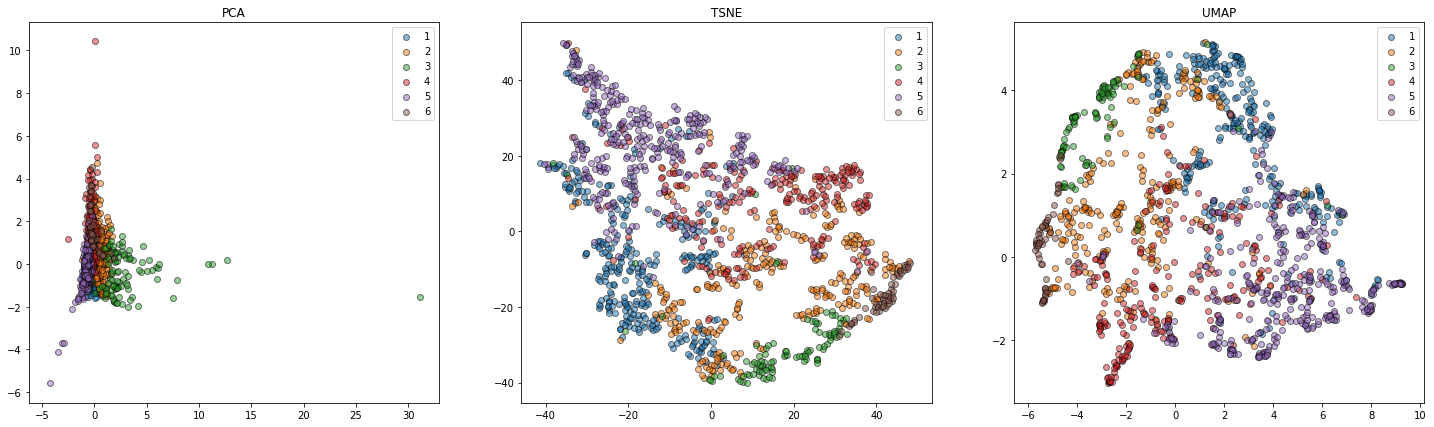

In [45]:
f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'UL'
clustering = ''
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 7 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_PROFILE' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_PROFILE' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'MBE'
clustering = '_KMEANS'
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 6 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'MBE'
clustering = '_SPECTRAL'
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 6 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

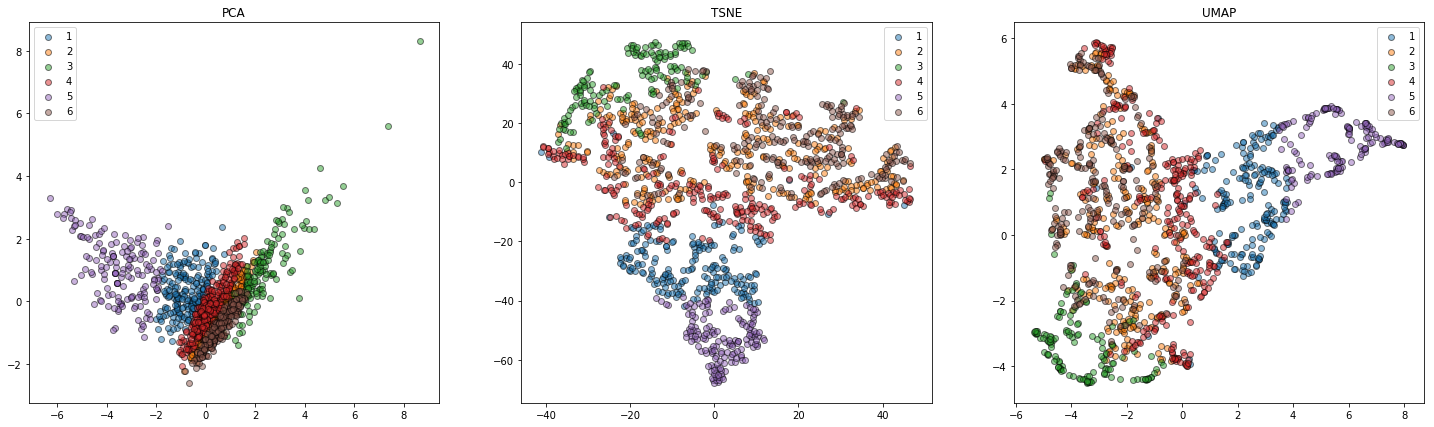

In [46]:
f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'TR'
clustering = ''
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 7 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_PROFILE' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_PROFILE' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'MT'
clustering = '_KMEANS'
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 6 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'MT'
clustering = '_SPECTRAL'
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 6 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

In [47]:
salurbal_df.head()

,Country,L1Name,L2Namev2,BECNURBPTCH,BECPTCHDENS,BECAWMNSHPINDX,BECAWMNNNGH,BECEFFMESHSIZE,BECAWAVGPTCHAREA,BECAWEDGDENS,BECPRSBRT,BECPRSSUBWAY,BECADCRCTYAVG,BECADINTDENS,BECADSTTDENS,BECADSTTPNODEAVG,BECADSTTLGAVG,BECURBTRVDELAYINDEX,UL_PROFILE,TR_PROFILE,CentLatitude,CentLongitude,TSNE_UL_X,TSNE_UL_Y,TSNE_TR_X,TSNE_TR_Y,PCA_UL_X,PCA_UL_Y,PCA_TR_X,PCA_TR_Y,UMAP_UL_X,UMAP_UL_Y,UMAP_TR_X,UMAP_TR_Y
0,Argentina,Bahia Blanca,Bahía Blanca,487,0.2131,5.1337,76.64910,77.6599,2644.8742,0.420828,0,0,1.032761,3.672485,939.287799,3.411006,144.004054,0.104629,1,6,-38.718318,-62.266348,-12.898190,-25.426403,45.061047,7.195621,0.302009,-1.061073,-0.409579,-1.957542,0.748505,4.651103,-3.774608,5.470527
1,Argentina,Buenos Aires,CABA - Comuna 12,1,0.0642,1.4735,76.50085,1557.1800,1557.1800,14.988633,1,1,1.010627,102.376535,18590.830836,3.619105,99.891610,0.168965,6,5,-34.564220,-58.491549,39.640919,-20.066622,10.185191,-54.655048,-0.005268,1.001441,-4.268277,0.046160,-5.292621,0.843872,5.570020,3.849124
2,Argentina,Buenos Aires,CABA - Comuna 13,13,0.8836,2.5395,60.04620,1264.0834,1359.9129,24.739527,1,1,1.026108,90.571453,16060.259206,3.473831,98.454629,0.240852,2,5,-34.554402,-58.457291,41.998650,-10.082724,8.833679,-52.408836,0.248292,2.442363,-3.540554,0.132009,-4.772605,-0.534074,5.248664,3.885665
3,Argentina,Buenos Aires,CABA - Comuna 4,8,0.3611,2.2122,67.16730,1990.2022,2091.1138,18.119355,1,1,1.027101,79.577418,14502.014548,3.361758,104.423094,0.156420,2,5,-34.644379,-58.388805,37.709305,-16.259701,8.453005,-48.949596,0.457925,1.425668,-3.031621,0.119105,-4.778886,0.604112,4.693229,3.651631
4,Argentina,Buenos Aires,CABA - Comuna 6,1,0.1460,1.2914,76.50085,684.9000,684.9000,19.798511,0,1,1.005764,83.147041,15379.258560,3.525963,106.145510,0.248183,6,5,-34.620928,-58.445874,43.747494,-16.740778,10.296473,-51.912312,-0.435903,1.580329,-3.545781,-0.307918,-5.716122,0.156179,5.138762,3.844375


In [48]:
salurbal_df.to_csv( '../data/base_l2_clean.csv', sep = ';', decimal = ',', index = False )

# Explanations

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
from __future__ import print_function
np.random.seed(1)

In [ ]:
iris = sklearn.datasets.load_iris()

In [ ]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(iris.data, iris.target, train_size=0.80)

In [ ]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train, labels_train)

In [ ]:
sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

In [ ]:
iris.target_names

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=iris.feature_names, class_names=iris.target_names, discretize_continuous=True)

In [ ]:
i = np.random.randint(0, test.shape[0])
exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=2, top_labels=1)

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
test.shape

In [ ]:
#salurbal_df[ [ 'MT_PROB1', 'MT_PROB2', 'MT_PROB3', 'MT_PROB4', 'MT_PROB5' ] ].sum( axis = 1 )

In [ ]:
salurbal_df[ mt_features ].dtypes

In [ ]:
salurbal_mx = salurbal_df[ mt_features ].values
salurbal_mx.shape

In [ ]:
salurbal_mx_probs = lambda x: salurbal_df[ [ 'MT_PROB1', 'MT_PROB2', 'MT_PROB3', 'MT_PROB4', 'MT_PROB5' ] ].values
salurbal_mx_probs

In [ ]:
salurbal_mx_probs( 1 )

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer( salurbal_mx, feature_names = mt_features, class_names = [ '1' , '2', '3', '4', '5' ] )

In [ ]:
i = np.random.randint( 0, salurbal_mx.shape[ 0 ] )
i

In [ ]:
exp = explainer.explain_instance( salurbal_mx[ i ], salurbal_mx_probs, num_features = 7 )